ML Lab_Sheet - 02

22UG1-0285 

K.G.G.R.Bandara

Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import KFold, cross_validate
from sklearn.pipeline import make_pipeline


Loading Dataset

In [4]:
df = pd.read_csv('..\\Dataset\\car data.csv')

Pre Processing

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Name       301 non-null    object 
 1   Year           301 non-null    int64  
 2   Selling_Price  301 non-null    float64
 3   Present_Price  301 non-null    float64
 4   Kms_Driven     301 non-null    int64  
 5   Fuel_Type      301 non-null    object 
 6   Seller_Type    301 non-null    object 
 7   Transmission   301 non-null    object 
 8   Owner          301 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 21.3+ KB


Drop meaningless column

In [12]:
df.drop('Car_Name', axis=1, inplace=True)

In [13]:
df.insert(0, 'Age', df['Year'].max() + 1 - df['Year'])
df.drop('Year', axis=1, inplace=True)

Outliers Using Boxplots

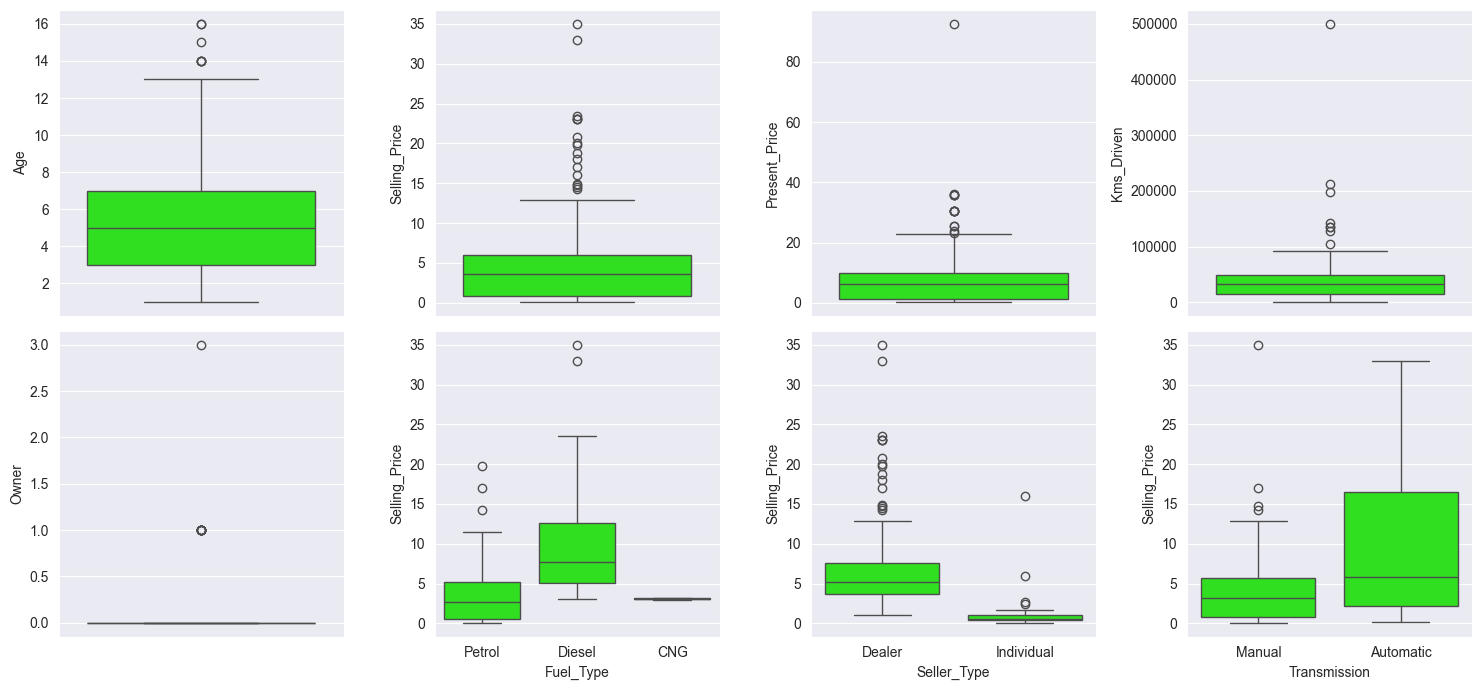

In [ ]:
sns.set_style('darkgrid')
colors = ["#15ff00", "#0051ff", "#d12525"]
sns.set_palette(sns.color_palette(colors))

OrderedCols = np.concatenate([df.select_dtypes(exclude='object').columns, df.select_dtypes(include='object').columns])
fig, ax = plt.subplots(2, 4, figsize=(15, 7), dpi=100)

for i, col in enumerate(OrderedCols):
    x = i // 4
    y = i % 4
    if i < 5:
        sns.boxplot(data=df, y=col, ax=ax[x, y])
    else:
        sns.boxplot(data=df, x=col, y='Selling_Price', ax=ax[x, y])
        
plt.tight_layout()
plt.show()


Outliers Using IQR

In [19]:
outliers_indexes = []
target = 'Selling_Price'

for col in df.select_dtypes(include='object').columns:
    for cat in df[col].unique():
        df1 = df[df[col] == cat]
        q1 = df1[target].quantile(0.25)
        q3 = df1[target].quantile(0.75)
        iqr = q3 - q1
        max_val = q3 + 1.5 * iqr
        min_val = q1 - 1.5 * iqr
        outlier_samples = df1[(df1[target] < min_val) | (df1[target] > max_val)]
        outliers_indexes.extend(outlier_samples.index.tolist())

for col in df.select_dtypes(exclude='object').columns:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    max_val = q3 + 1.5 * iqr
    min_val = q1 - 1.5 * iqr
    outlier_samples = df[(df[col] < min_val) | (df[col] > max_val)]
    outliers_indexes.extend(outlier_samples.index.tolist())

outliers_indexes = list(set(outliers_indexes))
print('{} outliers were identified, outliers are as follows:\n\n{}'.format(len(outliers_indexes), outliers_indexes))


38 outliers were identified, outliers are as follows:

[27, 37, 39, 50, 51, 52, 53, 54, 179, 184, 58, 59, 189, 62, 63, 64, 191, 66, 192, 196, 69, 193, 198, 201, 77, 205, 79, 80, 82, 84, 85, 86, 92, 93, 96, 97, 106, 241]


Removing and Labeling Outliers

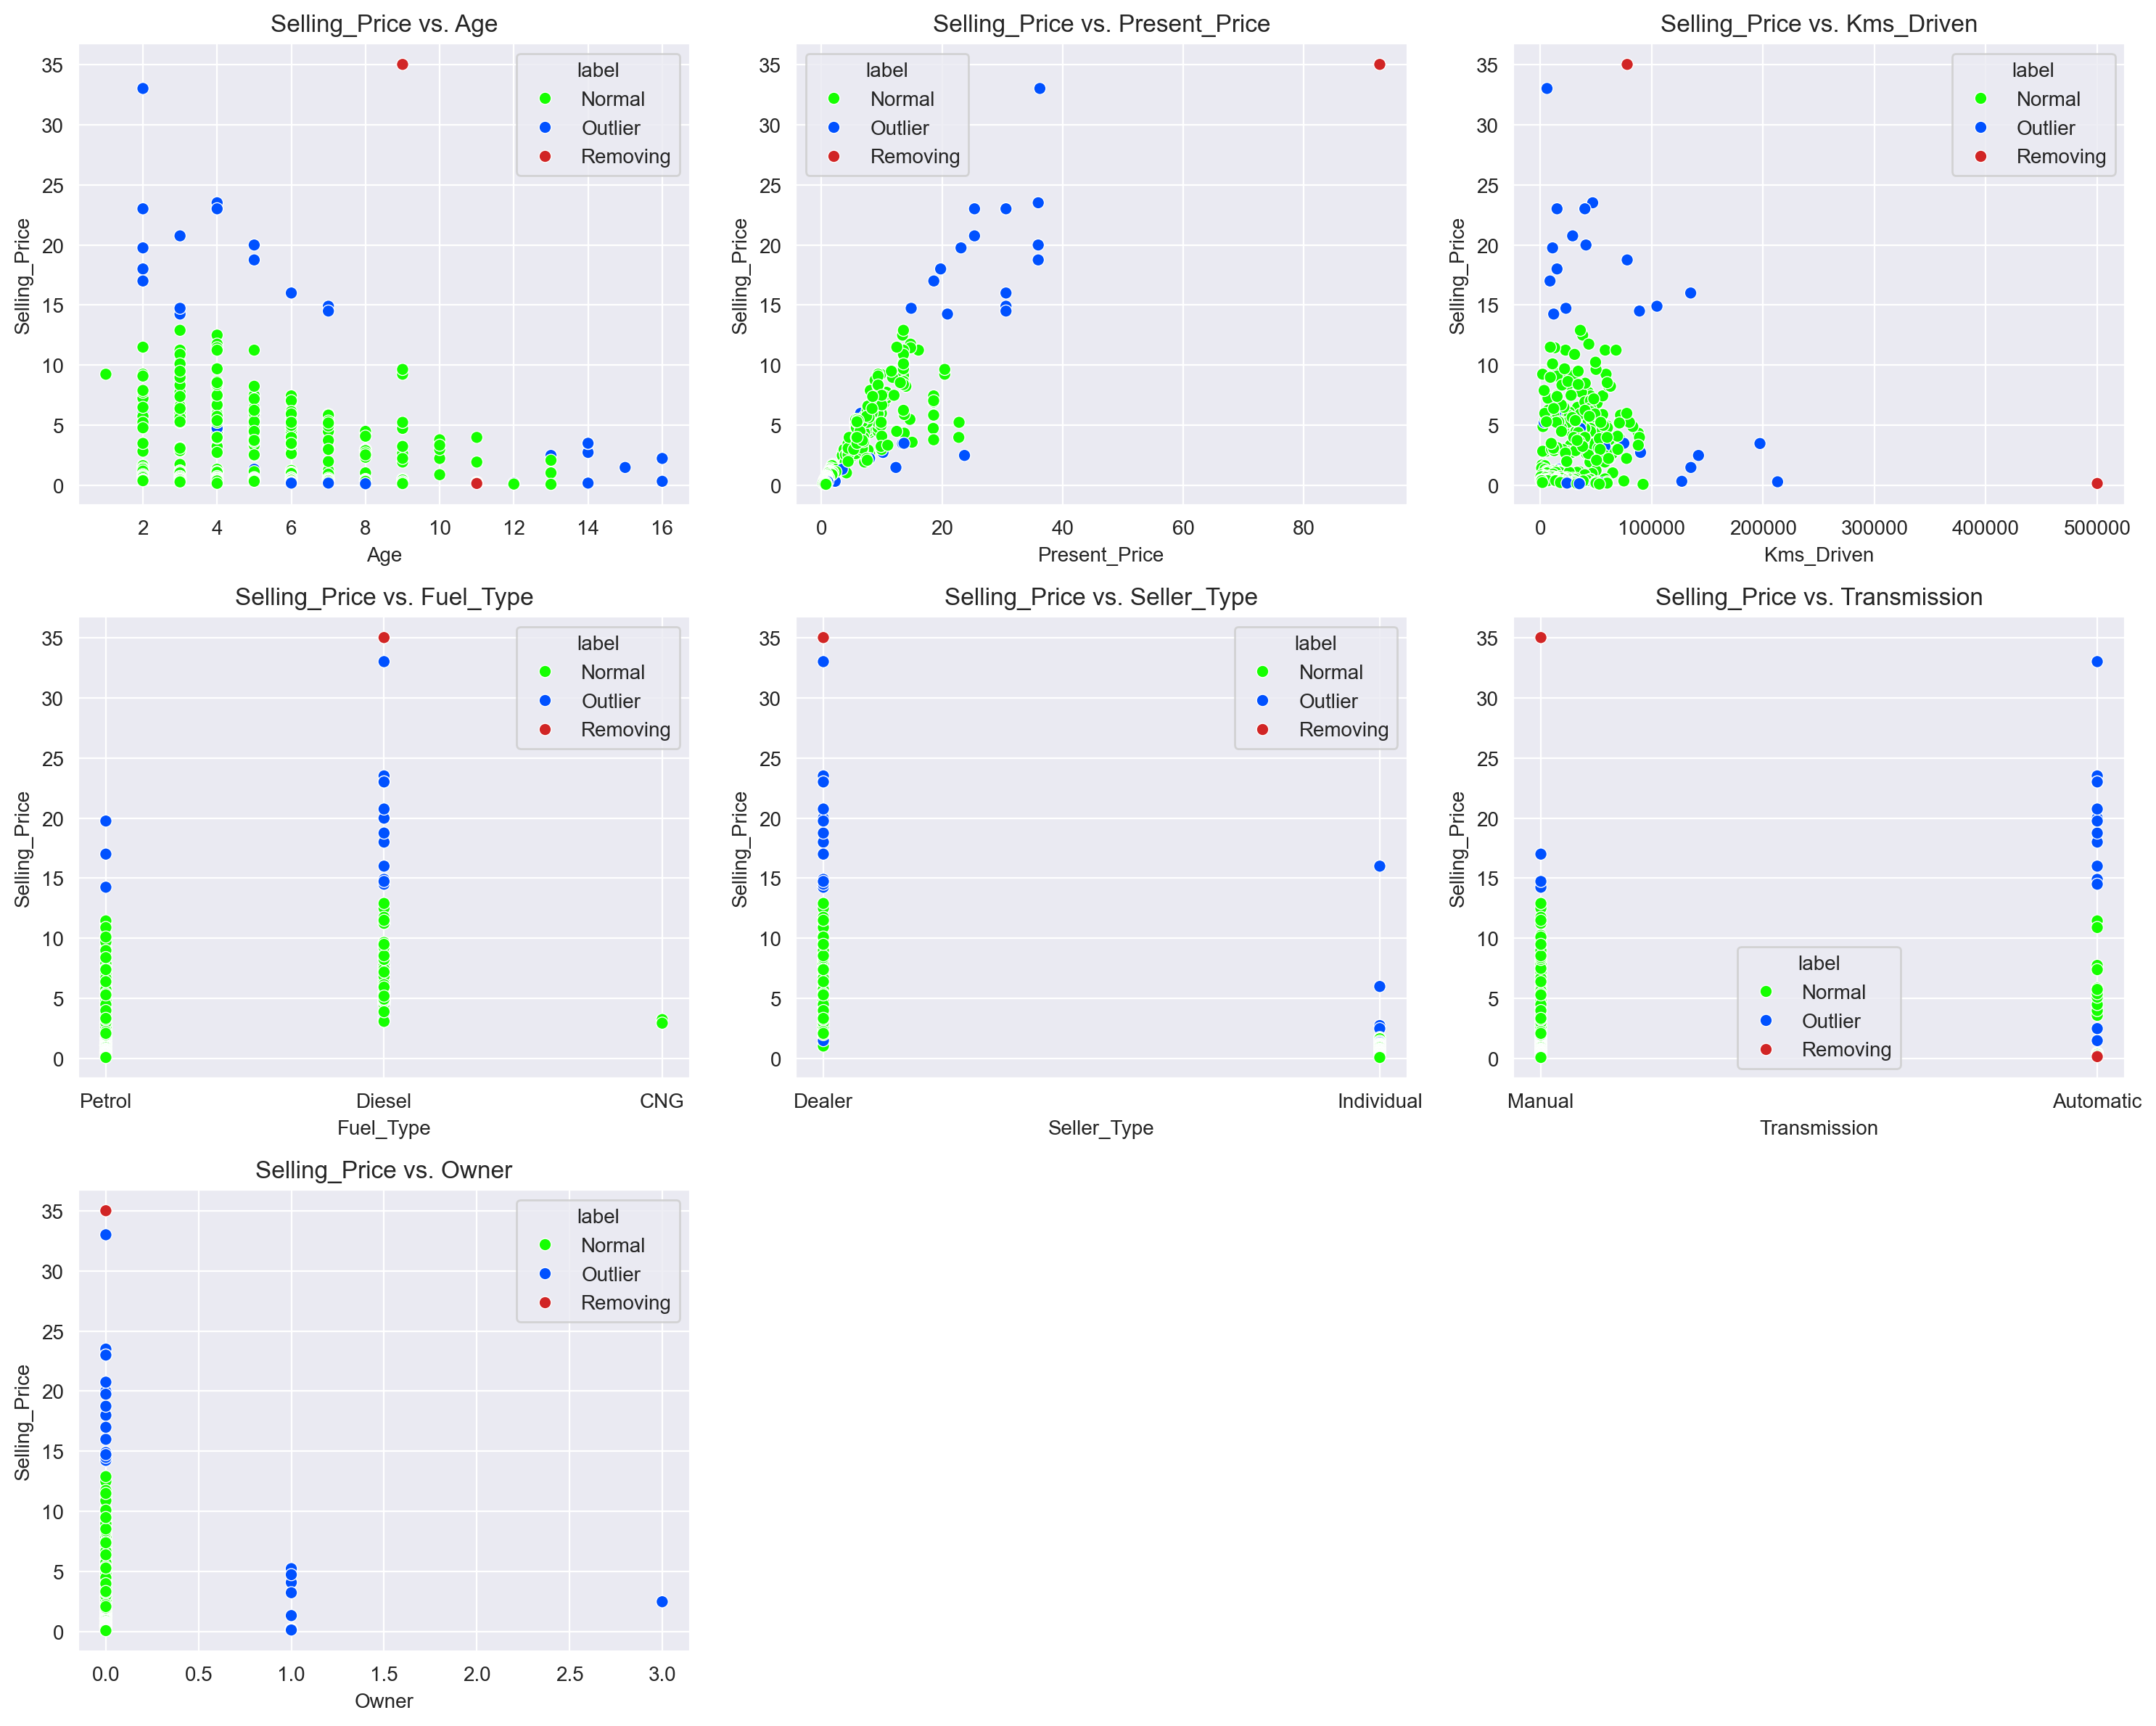

In [ ]:
df1 = df.copy()
df1['label'] = 'Normal'
df1.loc[outliers_indexes, 'label'] = 'Outlier'

removing_indexes = []
removing_indexes.extend(df1[df1[target] > 33].index)
removing_indexes.extend(df1[df1['Kms_Driven'] > 400000].index)
df1.loc[removing_indexes, 'label'] = 'Removing'

# Plotting
features = df.columns.drop(target)
fig, ax = plt.subplots(3, 3, figsize=(15, 12), dpi=200)

for i in range(len(features)):
    x, y = i // 3, i % 3
    sns.scatterplot(data=df1, x=features[i], y=target, hue='label', ax=ax[x, y])
    ax[x, y].set_title(f'{target} vs. {features[i]}')
ax[2, 1].axis('off')
ax[2, 2].axis('off')
plt.tight_layout()
plt.show()

Remove Outliers

In [ ]:
removing_indexes = list(set(removing_indexes))
df1 = df.copy()
df1.drop(removing_indexes, inplace=True)
df1.reset_index(drop=True, inplace=True)

Analyzing Dataset

In [23]:
NumCols = ['Age', 'Selling_Price', 'Present_Price', 'Kms_Driven', 'Owner']
CatCols = ['Fuel_Type', 'Seller_Type', 'Transmission']

Bivariate Analysis: Numarical

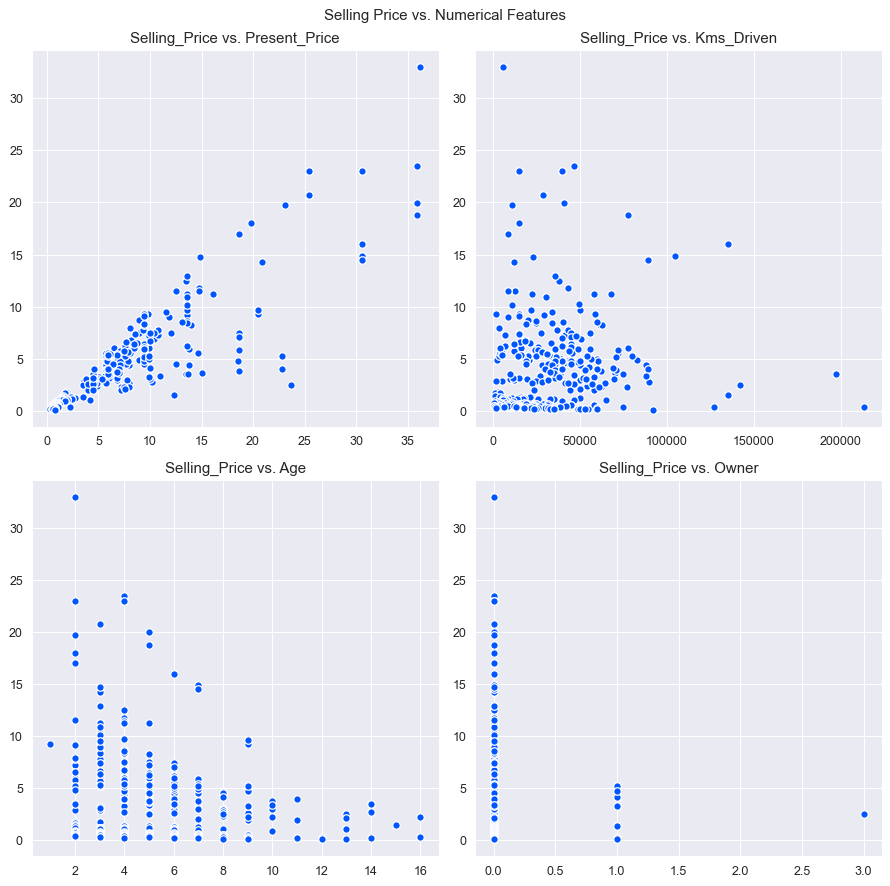

In [24]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10), dpi=90)
num_features = ['Present_Price', 'Kms_Driven', 'Age', 'Owner']

for i in range(len(num_features)):
    row, col = i // 2, i % 2
    ax[row, col].scatter(df1[num_features[i]], df1[target], color='#0055ff', edgecolors='w')
    ax[row, col].set_title(f'{target} vs. {num_features[i]}')

plt.suptitle('Selling Price vs. Numerical Features')
plt.tight_layout()
plt.show()


Encode Categorical Variables

In [25]:
df1 = pd.get_dummies(df1, columns=CatCols, drop_first=True)

Selling Price vs Categorical Features Bivariate Analysis

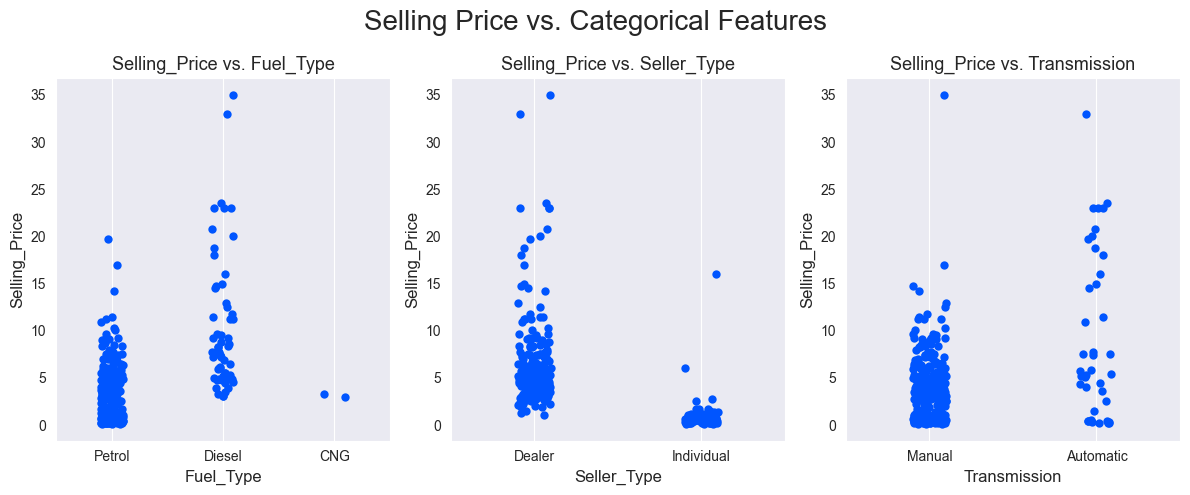

In [28]:
fig, axes = plt.subplots(nrows=1 ,ncols=3, figsize=(12,5), dpi=100)
cat_features = ['Fuel_Type', 'Seller_Type', 'Transmission']
target = 'Selling_Price'
c = '#0055ff'

for i in range(len(cat_features)):
    sns.stripplot(ax=axes[i], x=cat_features[i], y=target, data=df, size=6, color=c)
    axes[i].set_title('{} vs. {}'.format(target, cat_features[i]), size = 13)
    axes[i].set_xlabel(cat_features[i], size = 12)
    axes[i].set_ylabel(target, size = 12)
    axes[i].grid()

plt.suptitle('Selling Price vs. Categorical Features', size = 20)
plt.tight_layout()
plt.show()

Correlation Heatmap

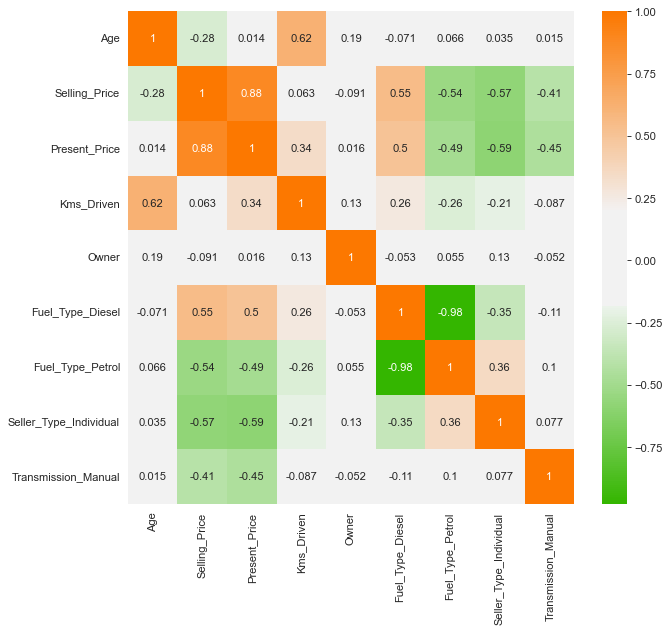

In [26]:
cmap = sns.diverging_palette(125, 28, s=100, l=65, sep=50, as_cmap=True)
plt.figure(figsize=(9, 8), dpi=80)
sns.heatmap(df1.corr(), annot=True, cmap=cmap)
plt.show()

Summary Statistics

In [30]:
print("Summary Statistics:\n")
display(df1[NumCols].describe().T)

print("\nValue Counts for Categorical Columns:\n")
for col in CatCols:
    print(f"\n{col}:\n{df[col].value_counts()}")

Summary Statistics:



,count,mean,std,min,25%,50%,75%,max
Age,299.0,5.341137,2.875028,1.00,3.00,5.0,7.000,16.00
Selling_Price,299.0,4.574849,4.779588,0.10,0.90,3.6,6.000,33.00
Present_Price,299.0,7.368060,7.124316,0.32,1.23,6.4,9.875,36.23
Kms_Driven,299.0,35261.234114,28183.470787,500.00,15000.00,32000.0,47500.000,213000.00
Owner,299.0,0.043478,0.248720,0.00,0.00,0.0,0.000,3.00



Value Counts for Categorical Columns:


Fuel_Type:
Fuel_Type
Petrol    239
Diesel     60
CNG         2
Name: count, dtype: int64

Seller_Type:
Seller_Type
Dealer        195
Individual    106
Name: count, dtype: int64

Transmission:
Transmission
Manual       261
Automatic     40
Name: count, dtype: int64


Distribution Plots (Histograms)

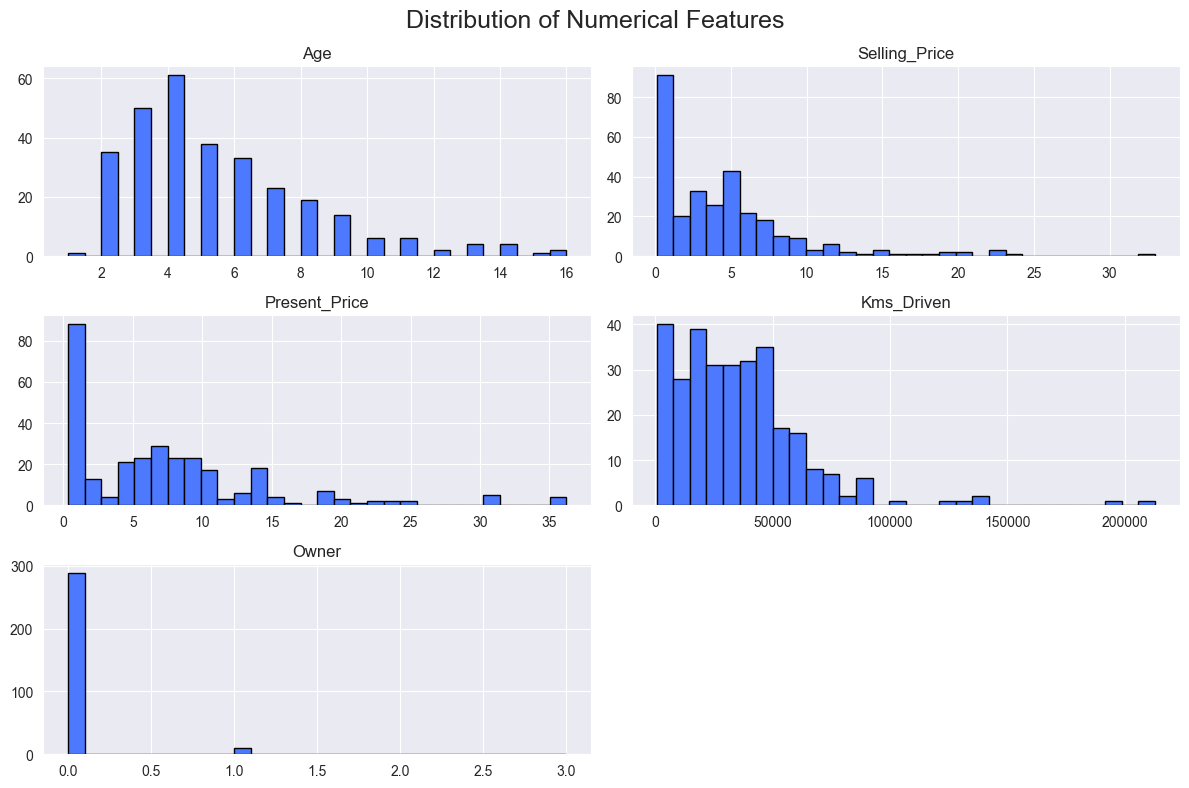

In [31]:
df1[NumCols].hist(figsize=(12, 8), bins=30, edgecolor='black', color='#4d79ff')

plt.suptitle('Distribution of Numerical Features', fontsize=18)
plt.tight_layout()
plt.show()

Pairplot for Relationship Overview

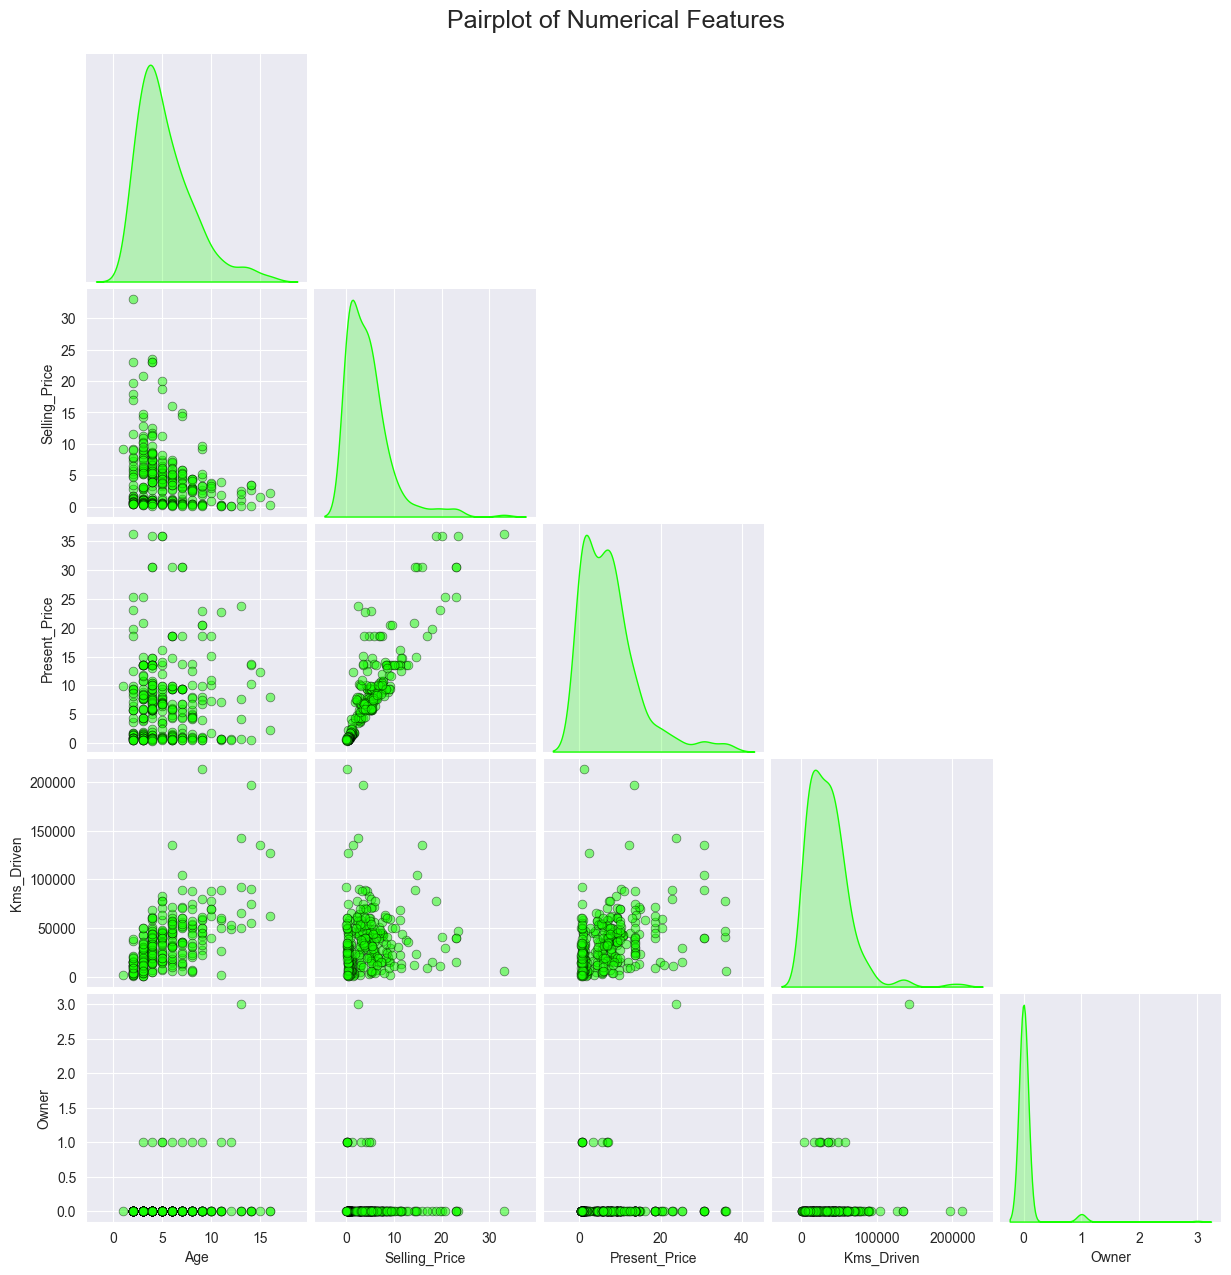

In [33]:
sns.pairplot(df1[NumCols], diag_kind='kde', plot_kws={'alpha':0.5, 's':40, 'edgecolor':'k'}, corner=True)

plt.suptitle('Pairplot of Numerical Features', y=1.02, fontsize=18)
plt.show()

Building the Model

In [ ]:
X = df1.drop('Selling_Price', axis=1)
y = df1['Selling_Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

#Normalizing the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Training the model
linear_reg = LinearRegression()
linear_reg.fit(X_train_scaled, y_train)

LinearRegression()

Intercept and Coefficients

In [36]:
pd.DataFrame(
    data=np.append(linear_reg.intercept_, linear_reg.coef_),
    index=['Intercept'] + [f'{col} Coef.' for col in X.columns],
    columns=['Value']
).sort_values(by='Value', ascending=False)

,Value
Intercept,4.302488
Present_Price Coef.,3.492729
Fuel_Type_Diesel Coef.,0.850217
Fuel_Type_Petrol Coef.,0.207319
Transmission_Manual Coef.,0.027375
Owner Coef.,-0.232722
Seller_Type_Individual Coef.,-0.377334
Kms_Driven Coef.,-0.589672
Age Coef.,-0.936339


Evaluate Model (Simple Test Set)

In [ ]:
def model_evaluation(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    MAE = metrics.mean_absolute_error(y_test, y_pred)
    MSE = metrics.mean_squared_error(y_test, y_pred)
    RMSE = np.sqrt(MSE)
    R2_Score = metrics.r2_score(y_test, y_pred)
    return pd.DataFrame([MAE, MSE, RMSE, R2_Score], index=['MAE', 'MSE', 'RMSE', 'R2-Score'], columns=[model_name])

model_evaluation(linear_reg, X_test_scaled, y_test, 'Linear Reg.')

,Linear Reg.
MAE,1.198867
MSE,3.714913
RMSE,1.927411
R2-Score,0.887245


Evaluate Model (K-Fold Cross-Validation(CV))

In [38]:
pipeline = make_pipeline(StandardScaler(), LinearRegression())
kf = KFold(n_splits=6, shuffle=True, random_state=0)
scoring = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error', 'r2']
result = cross_validate(pipeline, X, y, cv=kf, return_train_score=True, scoring=scoring)

pd.DataFrame({
    'Mean': [
        -result['test_neg_mean_absolute_error'].mean(),
        -result['test_neg_mean_squared_error'].mean(),
        -result['test_neg_root_mean_squared_error'].mean(),
        result['test_r2'].mean()
    ],
    'Std': [
        result['test_neg_mean_absolute_error'].std(),
        result['test_neg_mean_squared_error'].std(),
        result['test_neg_root_mean_squared_error'].std(),
        result['test_r2'].std()
    ]
}, index=['MAE', 'MSE', 'RMSE', 'R2-Score'])


,Mean,Std
MAE,1.154774,0.147377
MSE,3.131755,1.314319
RMSE,1.728702,0.378609
R2-Score,0.855703,0.033720


Compare Predictions (Visualization)

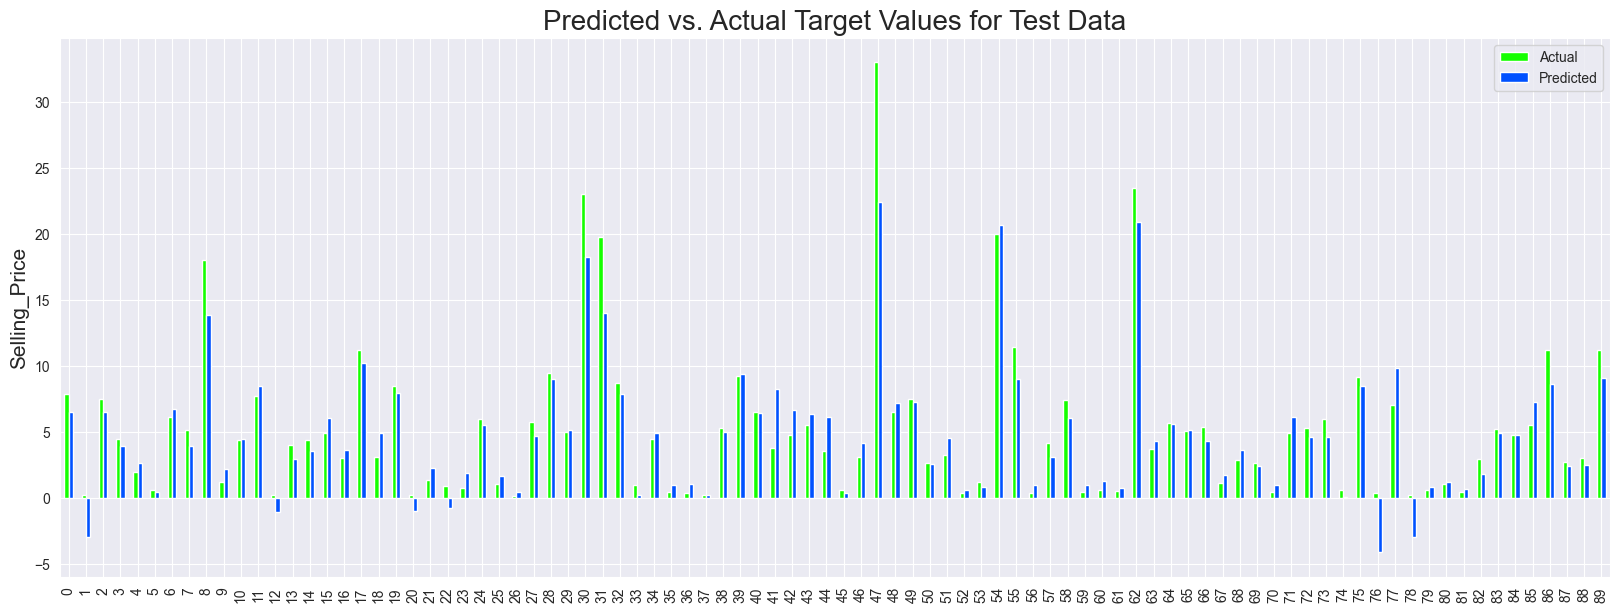

In [39]:
y_test_pred = linear_reg.predict(X_test_scaled)
df_comp = pd.DataFrame({'Actual': y_test, 'Predicted': y_test_pred})

def compare_plot(df_comp):
    df_comp.reset_index(drop=True, inplace=True)
    df_comp.plot(y=['Actual', 'Predicted'], kind='bar', figsize=(20, 7))
    plt.title('Predicted vs. Actual Target Values for Test Data', fontsize=20)
    plt.ylabel('Selling_Price', fontsize=15)
    plt.show()

compare_plot(df_comp)
